# Simulating and testing extractions of liquid crystal samples in quartz slides

In [6]:
import sys 
import os
# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor

## Material params and reference pulse

In [7]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

t_axis = np.arange(0, L * deltat, deltat)

In [8]:
lambda_ = 3e8 / 1e12 # wavelength at 1THz
alpha_silica = 2.6
k_silica = - alpha_silica*lambda_/(4 * np.pi)
print(f'Silica k value: {k_silica}')
n_silica = 1.963
d_silica = 1e-3

k_lc = -0.0001
n1_lc = 1.5  # n in one orientation
n2_lc = 1.9  # n in second orientation
d_lc = 0.02e-3  # (20 microns)

lc_sample1 = [(n_silica+1j*k_silica, d_silica), (n1_lc+1j*k_lc, d_lc), (n_silica+1j*k_silica, d_silica)]
lc_sample2 = [(n_silica+1j*k_silica, d_silica), (n2_lc+1j*k_lc, d_lc), (n_silica+1j*k_silica, d_silica)]

Silica k value: -6.207042780583918e-05


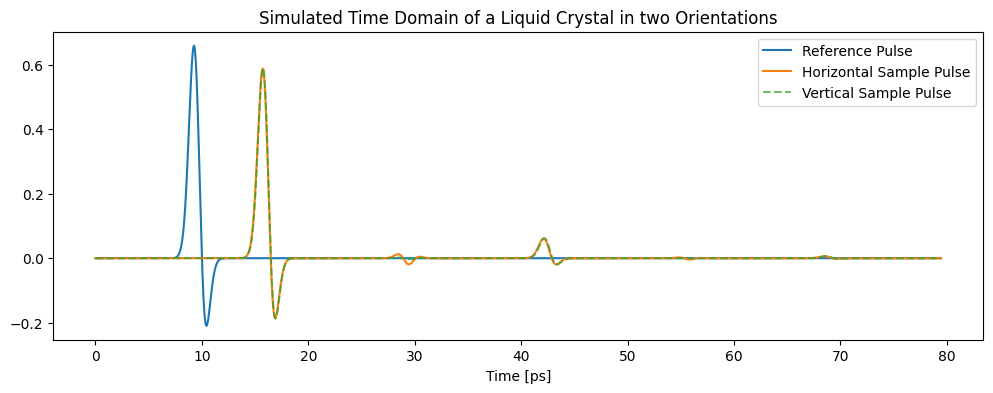

In [9]:
sample1_pulse = simulate_parallel(reference_pulse, lc_sample1, deltat, 0)[1][:L]
sample2_pulse = simulate_parallel(reference_pulse, lc_sample2, deltat, 0)[1][:L]


plt.figure(figsize=(12,4))
plt.title('Simulated Time Domain of a Liquid Crystal in two Orientations')
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, sample1_pulse.detach().cpu().numpy(), label='Horizontal Sample Pulse')
plt.plot(t_axis*1e12, sample2_pulse.detach().cpu().numpy(), label='Vertical Sample Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

### Find rough n values with delay calc 

In [10]:
c = 299792458 
sample1_numpy = sample1_pulse.detach().cpu().numpy()
sample2_numpy = sample2_pulse.detach().cpu().numpy()

ref_peak = t_axis[np.argmax(reference_pulse)]

sample1_peak = t_axis[np.argmax(sample1_numpy)]
sample2_peak = t_axis[np.argmax(sample2_numpy)]

total_time_delay1 = sample1_peak - ref_peak
total_time_delay2 = sample2_peak - ref_peak

time_from_slides = 2 * (d_silica * (n_silica - 1)) / c 
delay_from_lc1 = total_time_delay1 - time_from_slides
delay_from_lc2 = total_time_delay2 - time_from_slides

print(delay_from_lc1)

n_guess1 = ((delay_from_lc1 * c)/ d_lc) + 1
n_guess2 = ((delay_from_lc2 * c)/ d_lc) + 1

print(f'n for LC_1 guess: {n_guess1}')
print(f'n for LC_2 guess: {n_guess2}')

3.575552648359254e-14
n for LC_1 guess: 1.535961858580015
n for LC_2 guess: 1.8267605428400104


## Extract only on the LC component

### Bayesian optimization for configuration 1

In [11]:
optimize_mask = [
    (False, False, False),  # Quartz (fixed)
    (True, True, False),     # Sample (optimize just n&k)
    (False, False, False)   # Quartz (fixed)
]

# set up initial guess for bayesian optimization
lc_sample1_init = [
    (n_silica+1j*k_silica, d_silica), 
    (1.42+1j*k_lc, d_lc), 
    (n_silica+1j*k_silica, d_silica)
    ]

# Initialize optimizer
lc1_bayesian_opt = BayesianLayeredExtractor(
        reference_pulse, sample1_pulse, 
        deltat, 
        lc_sample1_init, 
        optimize_mask
    )

# Perform Bayesian optimization
lc1_bayesian_layers = lc1_bayesian_opt.bayesian_optimization(n_calls=40) 
print(f'Bayesian layers for config 1: {lc1_bayesian_layers}')

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 2 - n ∈ (1.3199999999999998, 1.52)
Layer 2 - k ∈ (-0.0101, 0.0099)
Bayesian layers for config 1: [((1.963-6.207042780583918e-05j), 0.001), ((1.5003425252750033+0.00016711127713578584j), 2e-05), ((1.963-6.207042780583918e-05j), 0.001)]


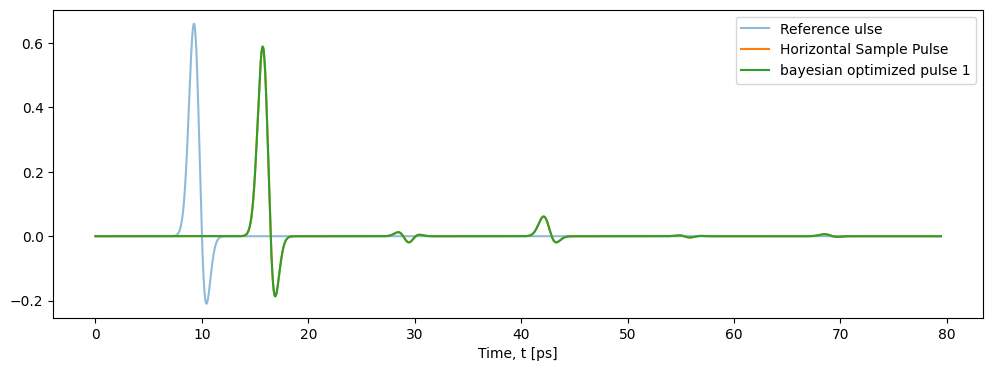

In [12]:
## Construct pulses with bayesian values
bayesian_pulse_1 = simulate_parallel(reference_pulse, lc1_bayesian_layers, deltat, 0)[1].detach().cpu().numpy()[:L]

# Plot reconstruction against 'experimental'
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='Reference ulse', alpha=0.5)
plt.plot(t_axis*1e12, sample1_pulse.detach().cpu().numpy(), label='Horizontal Sample Pulse')
plt.plot(t_axis*1e12, bayesian_pulse_1, label='bayesian optimized pulse 1')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

### Bayesian optimization for configuration 2

In [13]:
# set up initial guess for bayesian optimization
lc_sample2_init = [
    (n_silica+1j*k_silica, d_silica), 
    (1.82+1j*k_lc, d_lc), 
    (n_silica+1j*k_silica, d_silica)
    ]


# Initialize optimizer
lc2_bayesian_opt = BayesianLayeredExtractor(
        reference_pulse, sample2_pulse, 
        deltat, 
        lc_sample2_init, 
        optimize_mask
        )


# Perform Bayesian optimization
lc2_bayesian_layers = lc2_bayesian_opt.bayesian_optimization(n_calls=40) 
print(f'Bayesian layers for config 2: {lc2_bayesian_layers}')

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 2 - n ∈ (1.72, 1.9200000000000002)
Layer 2 - k ∈ (-0.0101, 0.0099)
Bayesian layers for config 2: [((1.963-6.207042780583918e-05j), 0.001), ((1.9003651434707298+0.00016710577892542142j), 2e-05), ((1.963-6.207042780583918e-05j), 0.001)]


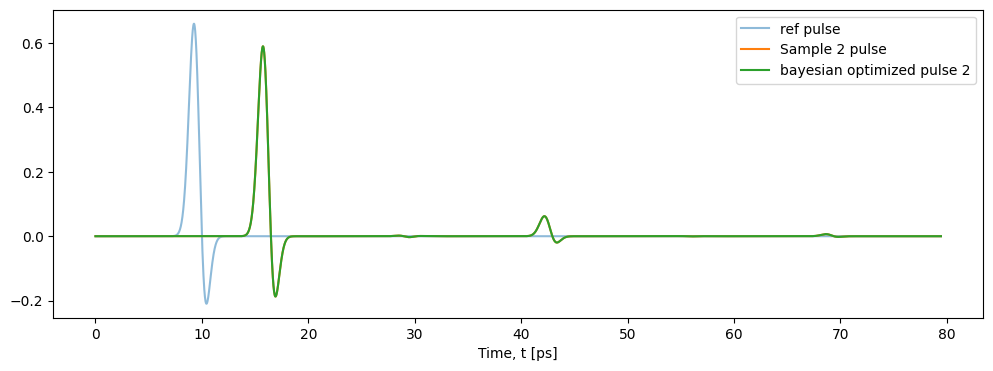

In [14]:
## Construct pulses with bayesian values
bayesian_pulse_2 = simulate_parallel(reference_pulse, lc2_bayesian_layers, deltat, 0)[1].detach().cpu().numpy()[:L]

plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse', alpha=0.5)
plt.plot(t_axis*1e12, sample2_pulse.detach().cpu().numpy(), label='Sample 2 pulse')
plt.plot(t_axis*1e12, bayesian_pulse_2, label='bayesian optimized pulse 2')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

### Gradient Descent optimization on configuration 1

Fine-tuning 2 parameters for 30 iterations.
Iteration 4, Loss: 3.329250e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.5005, k=0.00036, D=20.00 µm | Layer 2: n=1.9630, k=-0.00006, D=1000.00 µm
Iteration 9, Loss: 2.923034e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.4996, k=-0.00016, D=20.00 µm | Layer 2: n=1.9630, k=-0.00006, D=1000.00 µm
Iteration 14, Loss: 2.387059e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.5002, k=-0.00029, D=20.00 µm | Layer 2: n=1.9630, k=-0.00006, D=1000.00 µm
Iteration 19, Loss: 2.218867e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.4999, k=-0.00003, D=20.00 µm | Layer 2: n=1.9630, k=-0.00006, D=1000.00 µm
Iteration 24, Loss: 1.554722e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.5000, k=-0.00000, D=20.00 µm | Layer 2: n=1.9630, k=-0.00006, D=1000.00 µm
Iteration 29, Loss: 1.227678e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.5002, k=-0.00014, D=20.00 

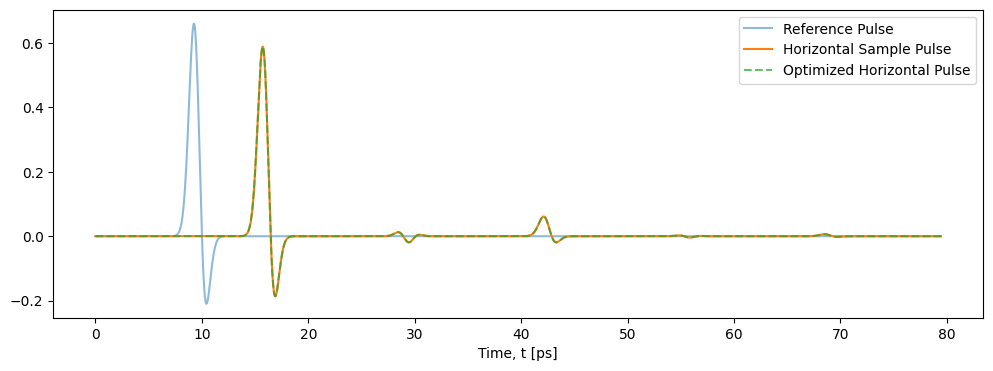

In [15]:
# Initialize gradient optimizer for sample 1
LC1_optimizer = LayeredExtractor(
        reference_pulse, sample1_pulse, 
        deltat, 
        lc1_bayesian_layers, 
        optimize_mask
        )

# Execute optimization
lc1_layers_opt = LC1_optimizer.optimize(num_iterations=30, updates=5)

# Reconstruct layers and signal with output
optimized_params1 = [
    (n_silica+1j*k_silica, d_silica),
    (lc1_layers_opt[1][0] + 1j * lc1_layers_opt[1][1], d_lc),
    (n_silica+1j*k_silica, d_silica)
    ]

optimized_pulse1 = simulate_parallel(reference_pulse, optimized_params1, deltat, 0)[1].detach().cpu().numpy()[:L]

# Plot reconstruction against 'experimental'
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', alpha=0.5)
plt.plot(t_axis*1e12, sample1_pulse.detach().cpu().numpy(), label='Horizontal Sample Pulse')
plt.plot(t_axis*1e12, optimized_pulse1, label='Optimized Horizontal Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

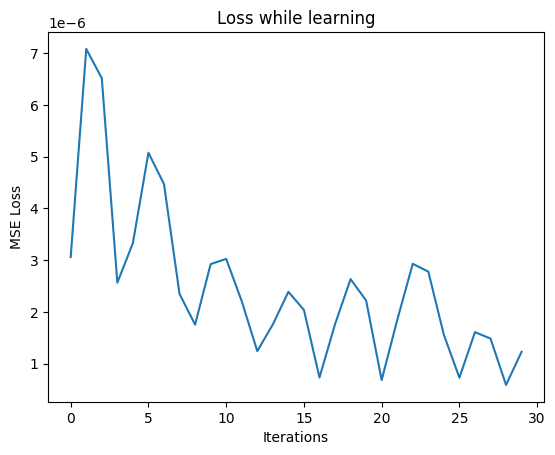

In [16]:
plt.plot(LC1_optimizer.loss_history)
plt.xlabel('Iterations')
plt.ylabel(f'MSE Loss')
plt.title('Loss while learning')
plt.show()

### Gradient Descent optimization on configuration 2

Fine-tuning 2 parameters for 30 iterations.
Iteration 4, Loss: 4.250163e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.9005, k=0.00034, D=20.00 µm | Layer 2: n=1.9630, k=-0.00006, D=1000.00 µm
Iteration 9, Loss: 3.484780e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.8996, k=-0.00010, D=20.00 µm | Layer 2: n=1.9630, k=-0.00006, D=1000.00 µm
Iteration 14, Loss: 3.004189e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.9002, k=-0.00031, D=20.00 µm | Layer 2: n=1.9630, k=-0.00006, D=1000.00 µm
Iteration 19, Loss: 2.773466e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.8999, k=-0.00004, D=20.00 µm | Layer 2: n=1.9630, k=-0.00006, D=1000.00 µm
Iteration 24, Loss: 1.710514e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.9000, k=0.00002, D=20.00 µm | Layer 2: n=1.9630, k=-0.00006, D=1000.00 µm
Iteration 29, Loss: 1.288828e-06, Layer 0: n=1.9630, k=-0.00006, D=1000.00 µm | Layer 1: n=1.9002, k=-0.00012, D=20.00 µ

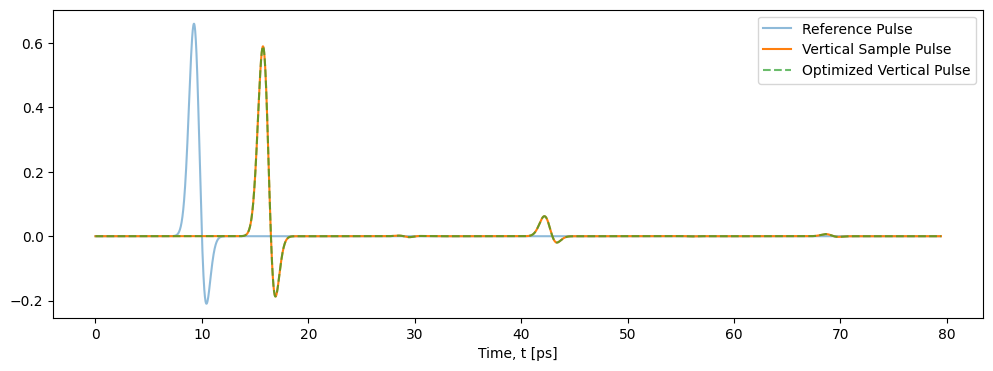

In [17]:
# Initialize gradient based optimizer for configuration 2
LC2_optimizer = LayeredExtractor(
        reference_pulse, sample2_pulse,
        deltat, 
        lc2_bayesian_layers, 
        optimize_mask
        )

# Execute gradient optimization
lc2_layers_opt = LC2_optimizer.optimize(num_iterations=30, updates=5)

# Reconstruct layers after optimization
optimized_params2 = [
    (n_silica+1j*k_silica, d_silica), 
    (lc2_layers_opt[1][0] + 1j * lc2_layers_opt[1][1], d_lc), 
    (n_silica+1j*k_silica, d_silica)
    ]

optimized_pulse2 = simulate_parallel(reference_pulse, optimized_params2, deltat, 0)[1].detach().cpu().numpy()[:L]

# Plot reconstruction against 'experimental'
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', alpha=0.5)
plt.plot(t_axis*1e12, sample2_pulse.detach().cpu().numpy(), label='Vertical Sample Pulse')
plt.plot(t_axis*1e12, optimized_pulse2, label='Optimized Vertical Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [18]:
optimized_params2, optimized_params1

([((1.963-6.207042780583918e-05j), 0.001),
  ((1.9001604318618774-0.00026867368069360964j), 2e-05),
  ((1.963-6.207042780583918e-05j), 0.001)],
 [((1.963-6.207042780583918e-05j), 0.001),
  ((1.500162959098816-0.00015567878654110245j), 2e-05),
  ((1.963-6.207042780583918e-05j), 0.001)])

In [19]:
print(f'Horizontal n residual: {np.abs(1.5 - 1.500162959098816)}')
print(f'Horizontal k residual: {-0.0001 - (-0.00015567878654110245)}')

print(f'vertical n residual: {np.abs(1.9 - 1.9001604318618774)}')
print(f'vertical k residual: {-0.0001 - (-0.00026867368069360964)}')


Horizontal n residual: 0.00016295909881591797
Horizontal k residual: 5.567878654110245e-05
vertical n residual: 0.00016043186187753022
vertical k residual: 0.00016867368069360965


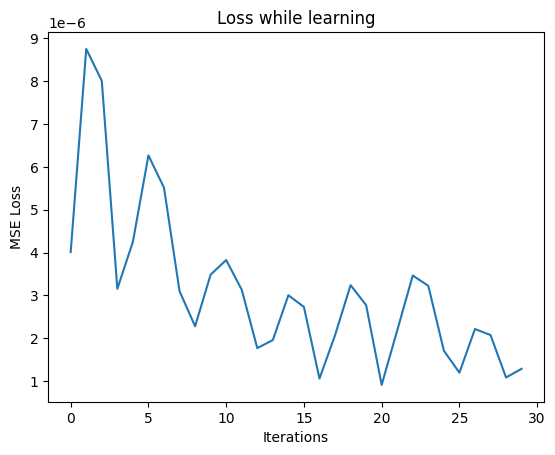

In [20]:
plt.plot(LC2_optimizer.loss_history)
plt.xlabel('Iterations')
plt.ylabel(f'MSE Loss')
plt.title('Loss while learning')
plt.show()

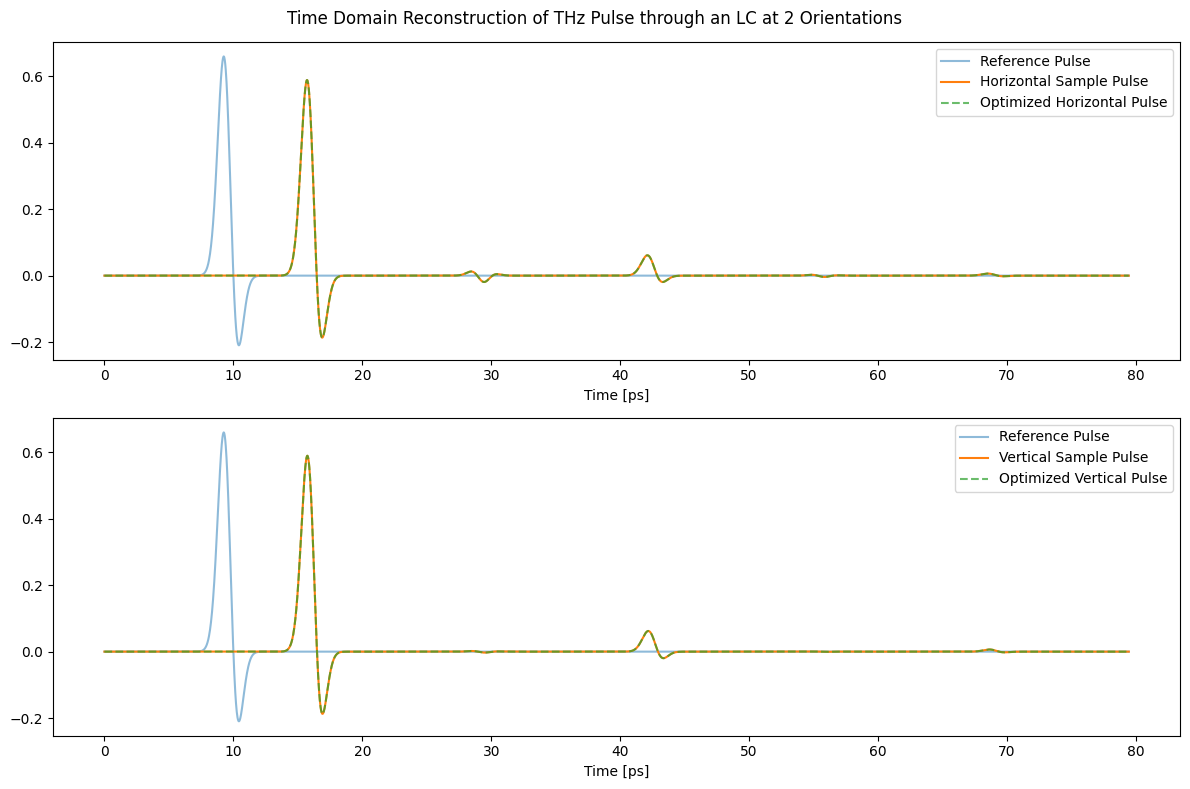

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# First subplot (Horizontal)
axs[0].plot(t_axis*1e12, reference_pulse, label='Reference Pulse', alpha=0.5)
axs[0].plot(t_axis*1e12, sample1_pulse.detach().cpu().numpy(), label='Horizontal Sample Pulse')
axs[0].plot(t_axis*1e12, optimized_pulse1, label='Optimized Horizontal Pulse', alpha=0.7, linestyle='--')
axs[0].set_xlabel('Time [ps]')
axs[0].legend()
axs[0].set_title('')  # Leave this empty so you can add a global title below

# Second subplot (Vertical)
axs[1].plot(t_axis*1e12, reference_pulse, label='Reference Pulse', alpha=0.5)
axs[1].plot(t_axis*1e12, sample2_pulse.detach().cpu().numpy(), label='Vertical Sample Pulse')
axs[1].plot(t_axis*1e12, optimized_pulse2, label='Optimized Vertical Pulse', alpha=0.7, linestyle='--')
axs[1].set_xlabel('Time [ps]')
axs[1].legend()

# Global title placeholder
fig.suptitle('Time Domain Reconstruction of THz Pulse through an LC at 2 Orientations') 

plt.tight_layout()  # Adjust layout to make room for title
plt.show()